# An Application to a Simulated Galaxy

This notebook gives an example of how to use AstroLink for exploration of astrophysical data.

First, we need to set up for our analysis...

In [43]:
# For interactive plots
%matplotlib widget

In [44]:
# Imports
import numpy as np
from astrolink import AstroLink
import matplotlib.pyplot as plt
from scipy.stats import beta

... and then we need some data:

In [45]:
P = np.load('../data/newhalo_young.npy')
print(P.shape, P.dtype)

(200359, 8) float32


`P` is a simulated galaxy expressed a numpy array consisting of 200359 points in 8 dimensions. Specifically, it is the 'newhalo_young' galaxy from [Galaxia](https://galaxia.sourceforge.net/) (originally from the [Johnston et al. (2008)](https://dx.doi.org/10.1086/592228) simulations) and the points represent stellar particles. The 8 dimensions (in the order that they appear within `P`) are; the three Cartesian spatial coordinates (x, y, z: in kpc); the three corresponding Cartesian velocities (vx, vy, vz: in km/s); and two elemental abundances ([Fe/H], [$\alpha$/Fe]: unitless).

## So what does the galaxy look like?

In [ ]:
# Plot the positions in space
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': '3d'})
ax.scatter(*P[:, :3].T, s=0.1, facecolors='k', edgecolors='k', alpha=0.1)
ax.set_aspect('equal')
ax.set_title('Positions of the stars')
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
ax.set_zlabel('z (kpc)')

In [ ]:
# Plot the velocity distribution
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': '3d'})
ax.scatter(*P[:, 3:6].T, s=0.1, facecolors='k', edgecolors='k', alpha=0.1)
ax.set_aspect('equal')
ax.set_title('Velocities of the stars')
ax.set_xlabel(r'$v_x$ (km/s)')
ax.set_ylabel(r'$v_y$ (km/s)')
ax.set_zlabel(r'$v_z$ (km/s)')

In [ ]:
# Plot the [alpha/Fe] versus [Fe/H] plane
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(*P[:, 6:].T, s=0.1, facecolors='k', edgecolors='k', alpha=0.5)
ax.set_aspect('equal')
ax.set_title(r'The [$\alpha$/Fe] versus [Fe/H] plane of the stars')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'[$\alpha$/Fe]')

So we can clearly see that there is structure within the halo. So how do we find that structure?

## AstroLink

Since the clusters that AstroLink finds are statistcally distinct overdensities within the feature space provided, one should carefully consider which feature space should actually be used for finding clusters, as different feature spaces will produce clusters with different meanings.

Or we could just explore the data and choose multiple feature space combinations to cover all bases, namely:
* Positions
* Velocities
* Position-Velocities
* Position-Abundances
* Velocity-Abundances
* Position-Velocity-Abundances

> [!NOTE]
> Using the abundance feature space alone for clustering gives spurious results because the underyling probability distribution is not well approximated by the kernel density estimate that AstroLink uses.

In [46]:
#Initialise the AstroLink objects
c_pos = AstroLink(P[:, :3], adaptive = 0)       # Feature space density is already meaningful without rescaling, so we set adaptive = 0
c_vel = AstroLink(P[:, 3:6], adaptive = 0)      # Feature space density is already meaningful without rescaling, so we set adaptive = 0
c_posvel = AstroLink(P[:, :6])
c_posabu = AstroLink(P[:, [0, 1, 2, 6, 7]])
c_velabu = AstroLink(P[:, 3:])
c_posvelabu = AstroLink(P)

# Run AstroLink over the different feature spaces
c_pos.run()             # This first run will take longer because it compiles the numba jitted functions
c_vel.run()
c_posvel.run()
c_posabu.run()
c_velabu.run()
c_posvelabu.run()

AstroLink: Started             | 2024-03-28 11:03:43
AstroLink: Completed           | 2024-03-28 11:03:44       
AstroLink: Started             | 2024-03-28 11:03:44
AstroLink: Completed           | 2024-03-28 11:03:44       
AstroLink: Started             | 2024-03-28 11:03:44
AstroLink: Completed           | 2024-03-28 11:03:44       
AstroLink: Started             | 2024-03-28 11:03:44
AstroLink: Completed           | 2024-03-28 11:03:45       
AstroLink: Started             | 2024-03-28 11:03:45
AstroLink: Completed           | 2024-03-28 11:03:45       
AstroLink: Started             | 2024-03-28 11:03:45
AstroLink: Completed           | 2024-03-28 11:03:45       
AstroLink: Started             | 2024-03-28 11:03:45
AstroLink: Completed           | 2024-03-28 11:03:46       


So now that AstroLink has clustered the data in various feature spaces, we should see what it has found.

In [70]:
# Create a function to make some informative plots
def make_plots(c, feature_space_str, P = P):
    # Fig to fit 5 plots
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(f'Structure in {feature_space_str} space', y = 1, fontsize = 'x-large')

    # Ordered-density plot with clusters coloured
    ax = fig.add_subplot(411)
    logRho_ordered = c.logRho[c.ordering]
    ax.plot(range(c.n_samples), logRho_ordered, 'k-', lw = 0.1, zorder = 2)
    ax.fill_between(range(c.n_samples), logRho_ordered, 0, color = 'k', label = c.ids[0], zorder = 1)
    rootClstBool = np.ones(c.n_samples, dtype = np.bool_)
    for i, (clst, clst_id) in enumerate(zip(c.clusters, c.ids)):
        if i > 0:
            rootClstBool[clst[0]:clst[1]] = 0
            ord_dens_clst = logRho_ordered[clst[0]:clst[1]]
            ax.fill_between(range(clst[0], clst[1]), ord_dens_clst, ord_dens_clst.min(), color = f"C{(i - 1)%10}", label = clst_id, zorder = 1)
    ax.set_title('Ordered density plot', y = 1, pad = 0, va = 'bottom')
    ax.set_xlabel('Ordered Index')
    ax.set_ylabel(r'$\log\hat\rho$')
    ax.set_xlim(0, c.n_samples - 1)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])
    ax.legend(loc = 'lower left', ncols = np.ceil(c.ids.size/4))
    
    # Prominence distribution with fitted model and significance value
    ax = fig.add_subplot(412)
    ax.hist(c.prominences_leq, bins = 'fd', color = 'k', alpha = 0.5, density = True)
    xs = beta.ppf(np.linspace(0, 1, 10**4), c.pFit[1], c.pFit[2])
    ax.plot(xs, beta.pdf(xs, c.pFit[1], c.pFit[2]), 'r-', lw = 1)
    ax.axvline(c.pFit[0], 0, 1, color = 'b', ls = '--', lw = 1)
    posSval = c.pFit[0] + 0.01*c.prominences_leq.max()
    ax.text(posSval, ax.get_ylim()[1]/2, f"S = {c.S:.2f}", color = 'royalblue', ha = 'left', va = 'center', rotation = 90)
    ax.set_title('Prominence distribution with fitted model', y = 1, pad = 0, va = 'bottom')
    ax.set_xlabel('Prominence')
    ax.set_ylabel('Probability density')
    ax.set_xlim(0, np.ceil(11*max(c.prominences_leq.max(), posSval))/10)
    ax.set_yticks([])

    # Positions of the stars in space with cluster coloured
    ax = fig.add_subplot(234, projection='3d')
    pos = P[:, :3]
    ax.scatter(*pos[rootClstBool].T, s = 0.1, facecolors = 'none', edgecolors = 'k', alpha = 0.05)
    for i, (clst, clst_id) in enumerate(zip(c.clusters, c.ids)):
        if i > 0:
            clst_ind = c.ordering[clst[0]:clst[1]]
            ax.scatter(*pos[clst_ind].T, s = 0.5, facecolors = f"C{(i - 1)%10}", edgecolors = 'none')
    ax.set_aspect('equal')
    ax.set_title('Positions of the stars')
    ax.set_xlabel('x (kpc)')
    ax.set_ylabel('y (kpc)')
    ax.set_zlabel('z (kpc)')

    # Positions of the stars in space with clusters coloured
    ax = fig.add_subplot(235, projection='3d')
    vel = P[:, 3:6]
    ax.scatter(*vel[rootClstBool].T, s = 0.1, facecolors = 'none', edgecolors = 'k', alpha = 0.05)
    for i, (clst, clst_id) in enumerate(zip(c.clusters, c.ids)):
        if i > 0:
            clst_ind = c.ordering[clst[0]:clst[1]]
            ax.scatter(*vel[clst_ind].T, s = 0.5, facecolors = f"C{(i - 1)%10}", edgecolors = 'none')
    ax.set_aspect('equal')
    ax.set_title('Velocities of the stars')
    ax.set_xlabel(r'$v_x$ (km/s)')
    ax.set_ylabel(r'$v_y$ (km/s)')
    ax.set_zlabel(r'$v_z$ (km/s)')

    # Plot the [alpha/Fe] versus [Fe/H] plane with clusters coloured
    ax = fig.add_subplot(236)
    abu = P[:, 6:]
    ax.scatter(*abu[rootClstBool].T, s = 0.2, facecolors = 'none', edgecolors = 'k', alpha = 0.5)
    for i, (clst, clst_id) in enumerate(zip(c.clusters, c.ids)):
        if i > 0:
            clst_ind = c.ordering[clst[0]:clst[1]]
            ax.scatter(*abu[clst_ind].T, s = 1, facecolors = f"C{(i - 1)%10}", edgecolors = 'none')
    ax.set_aspect('equal')
    ax.set_title(r'The [$\alpha$/Fe] versus [Fe/H] plane of the stars')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel(r'[$\alpha$/Fe]')

    plt.tight_layout()

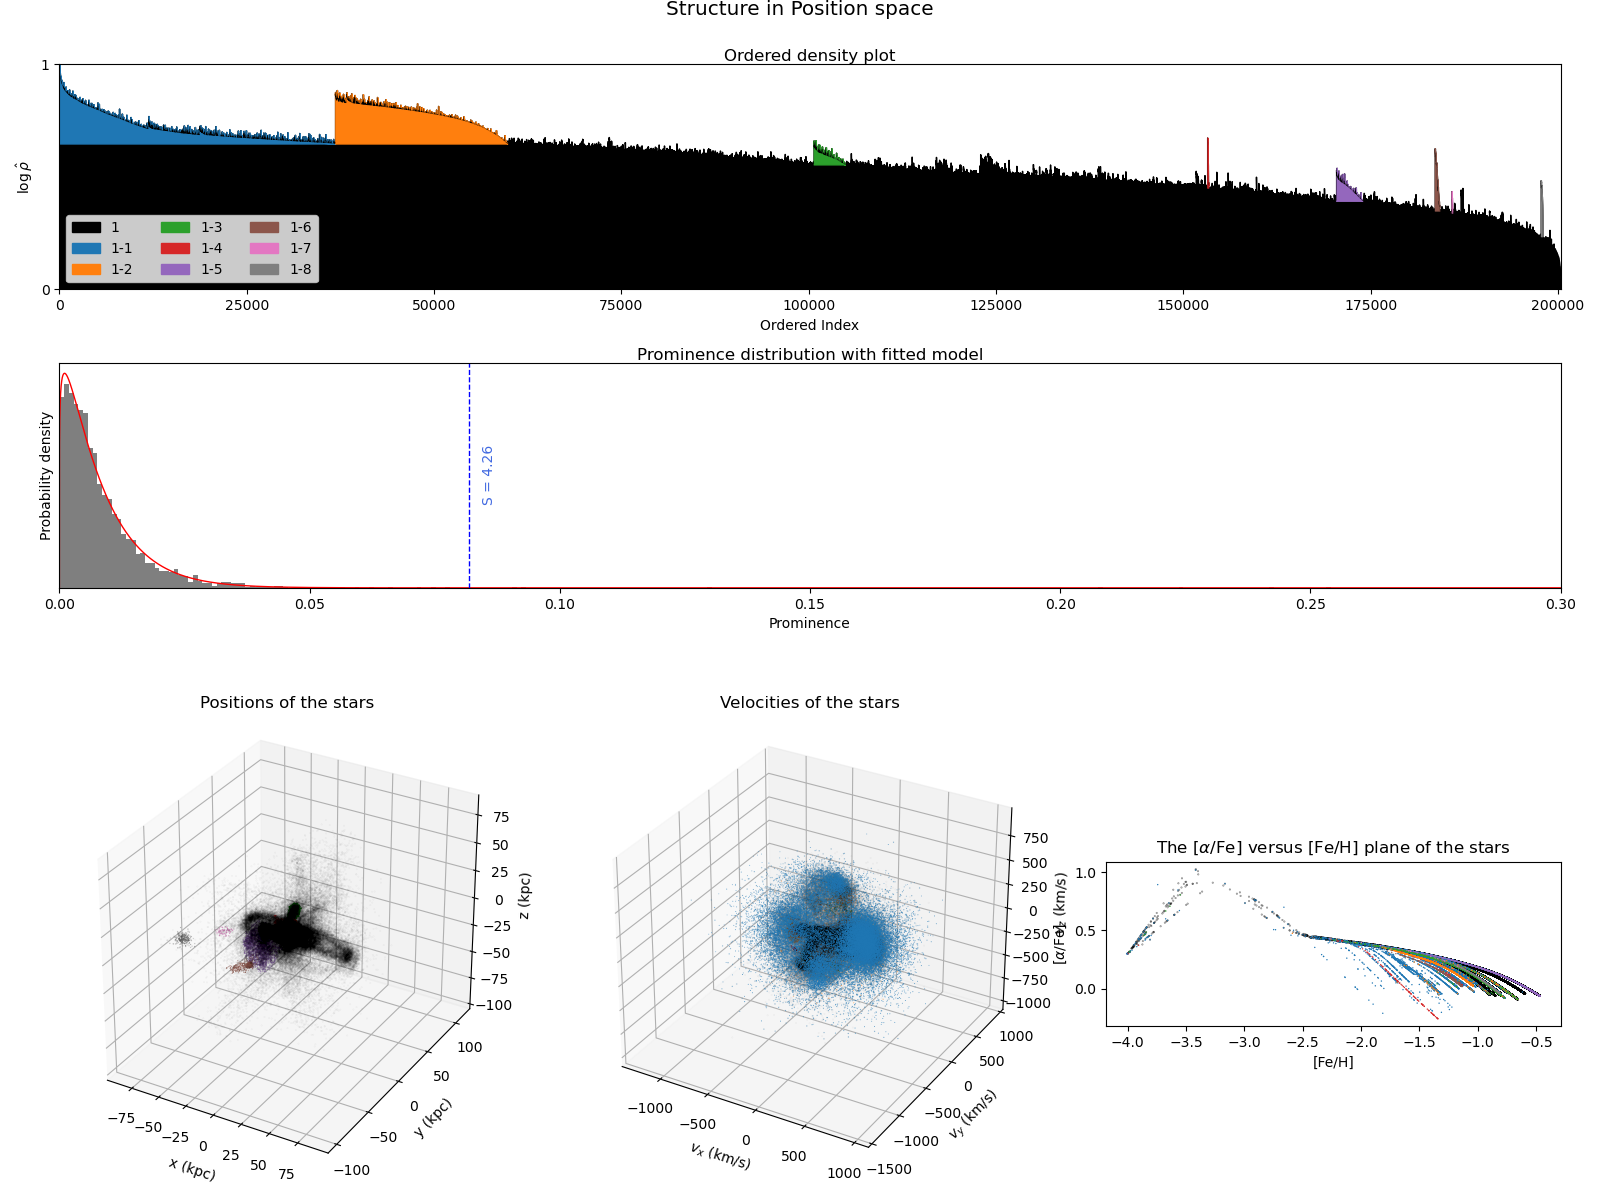

In [71]:
# Make plots for clustering in position space
make_plots(c_pos, 'Position')

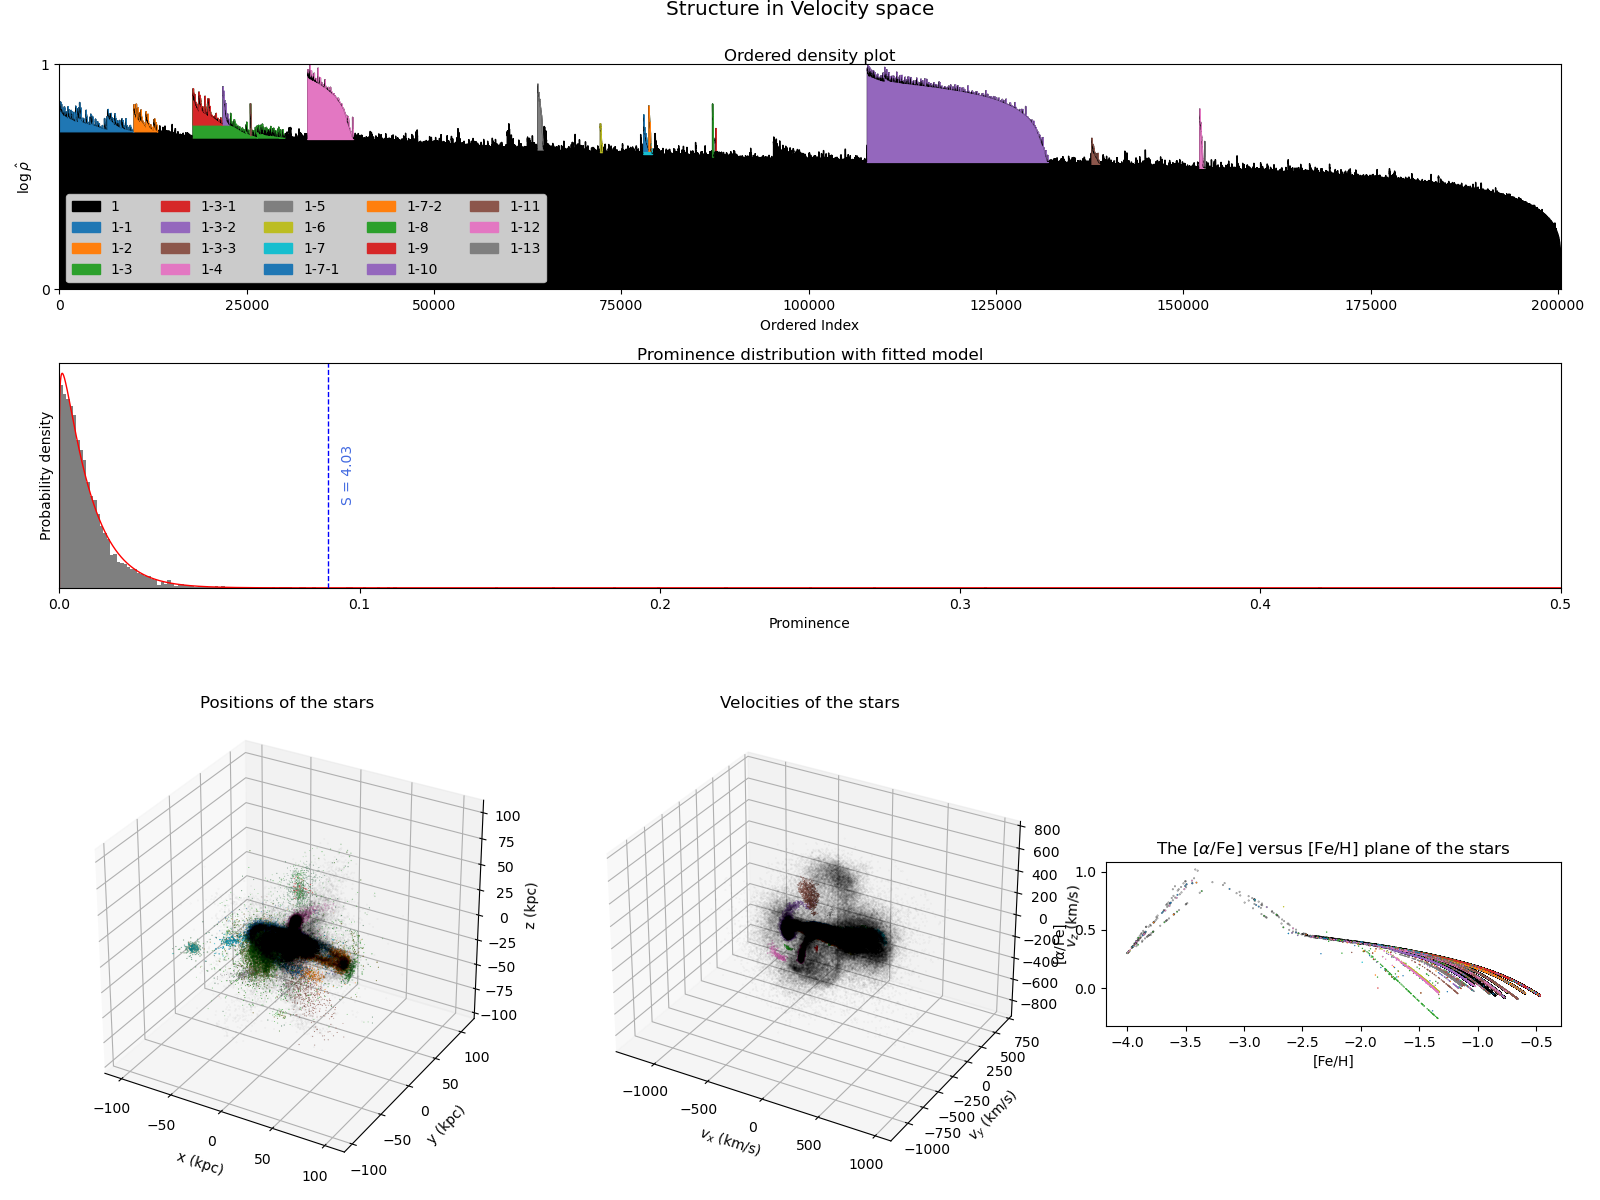

In [72]:
# Make plots for clustering in velocity space
make_plots(c_vel, 'Velocity')

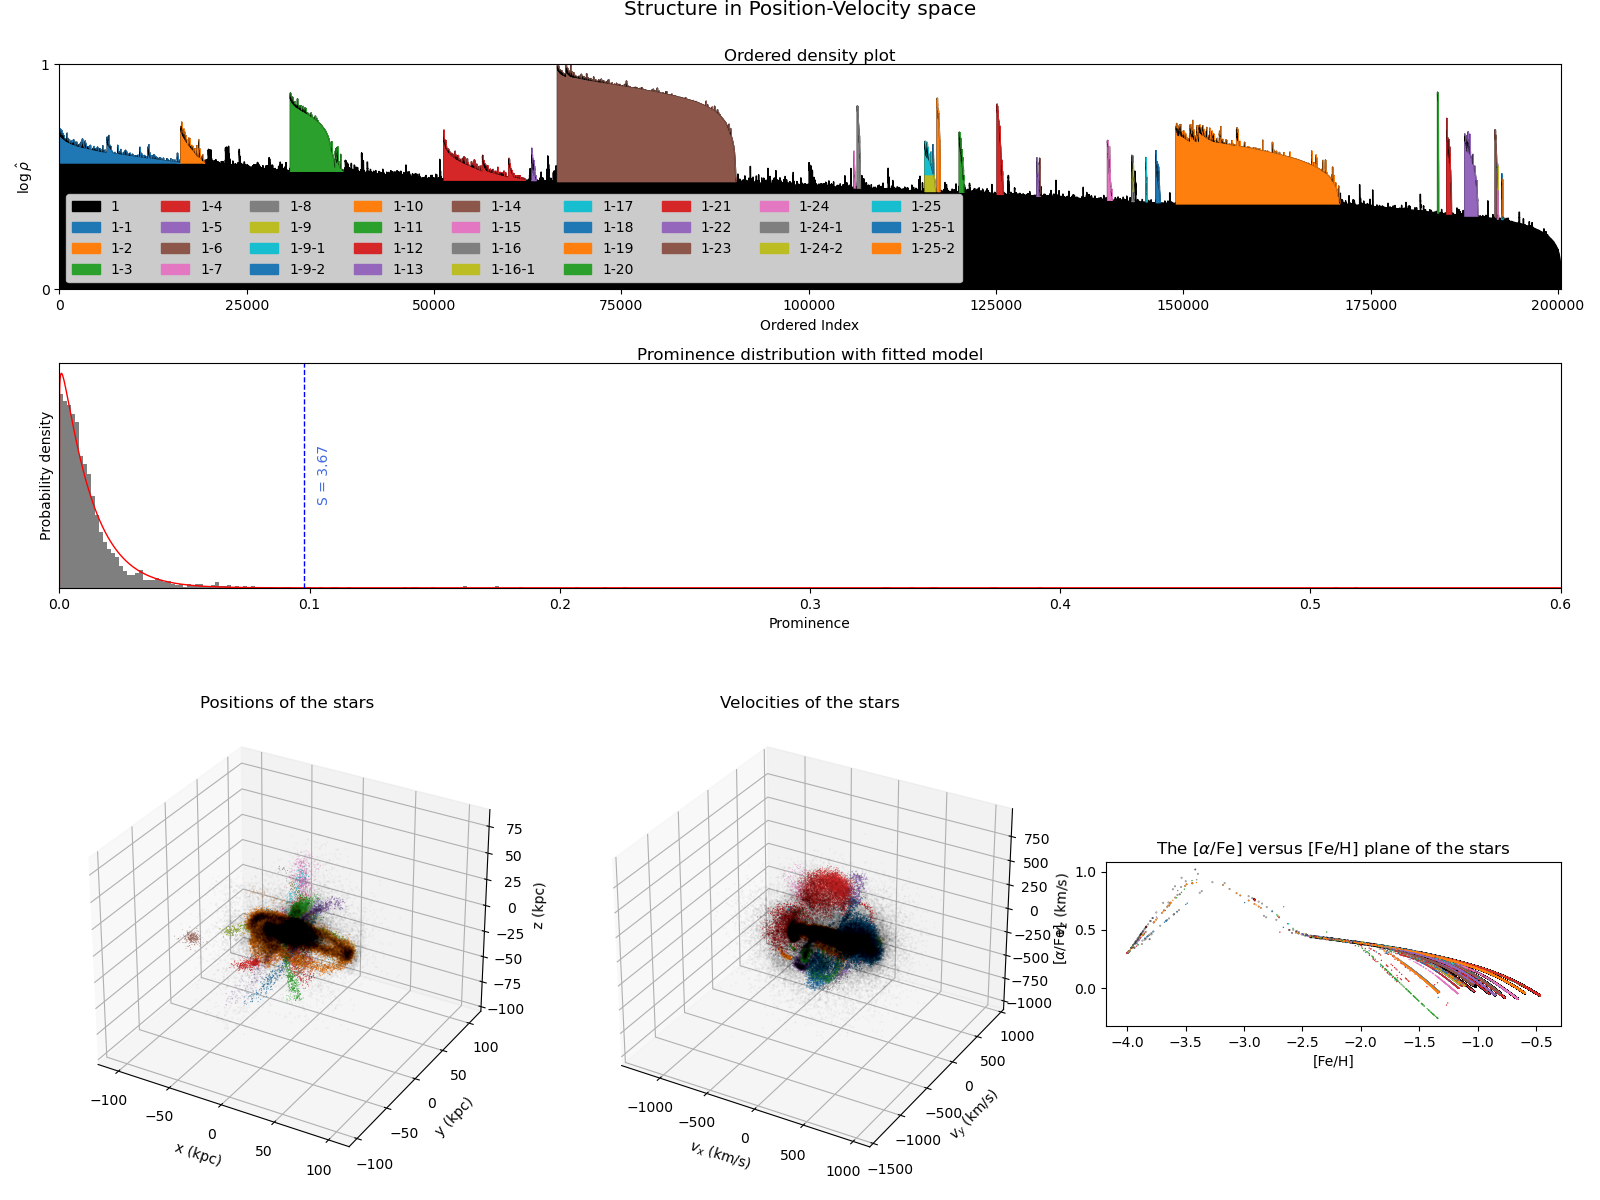

In [73]:
# Make plots for clustering in position-velocity space
make_plots(c_posvel, 'Position-Velocity')

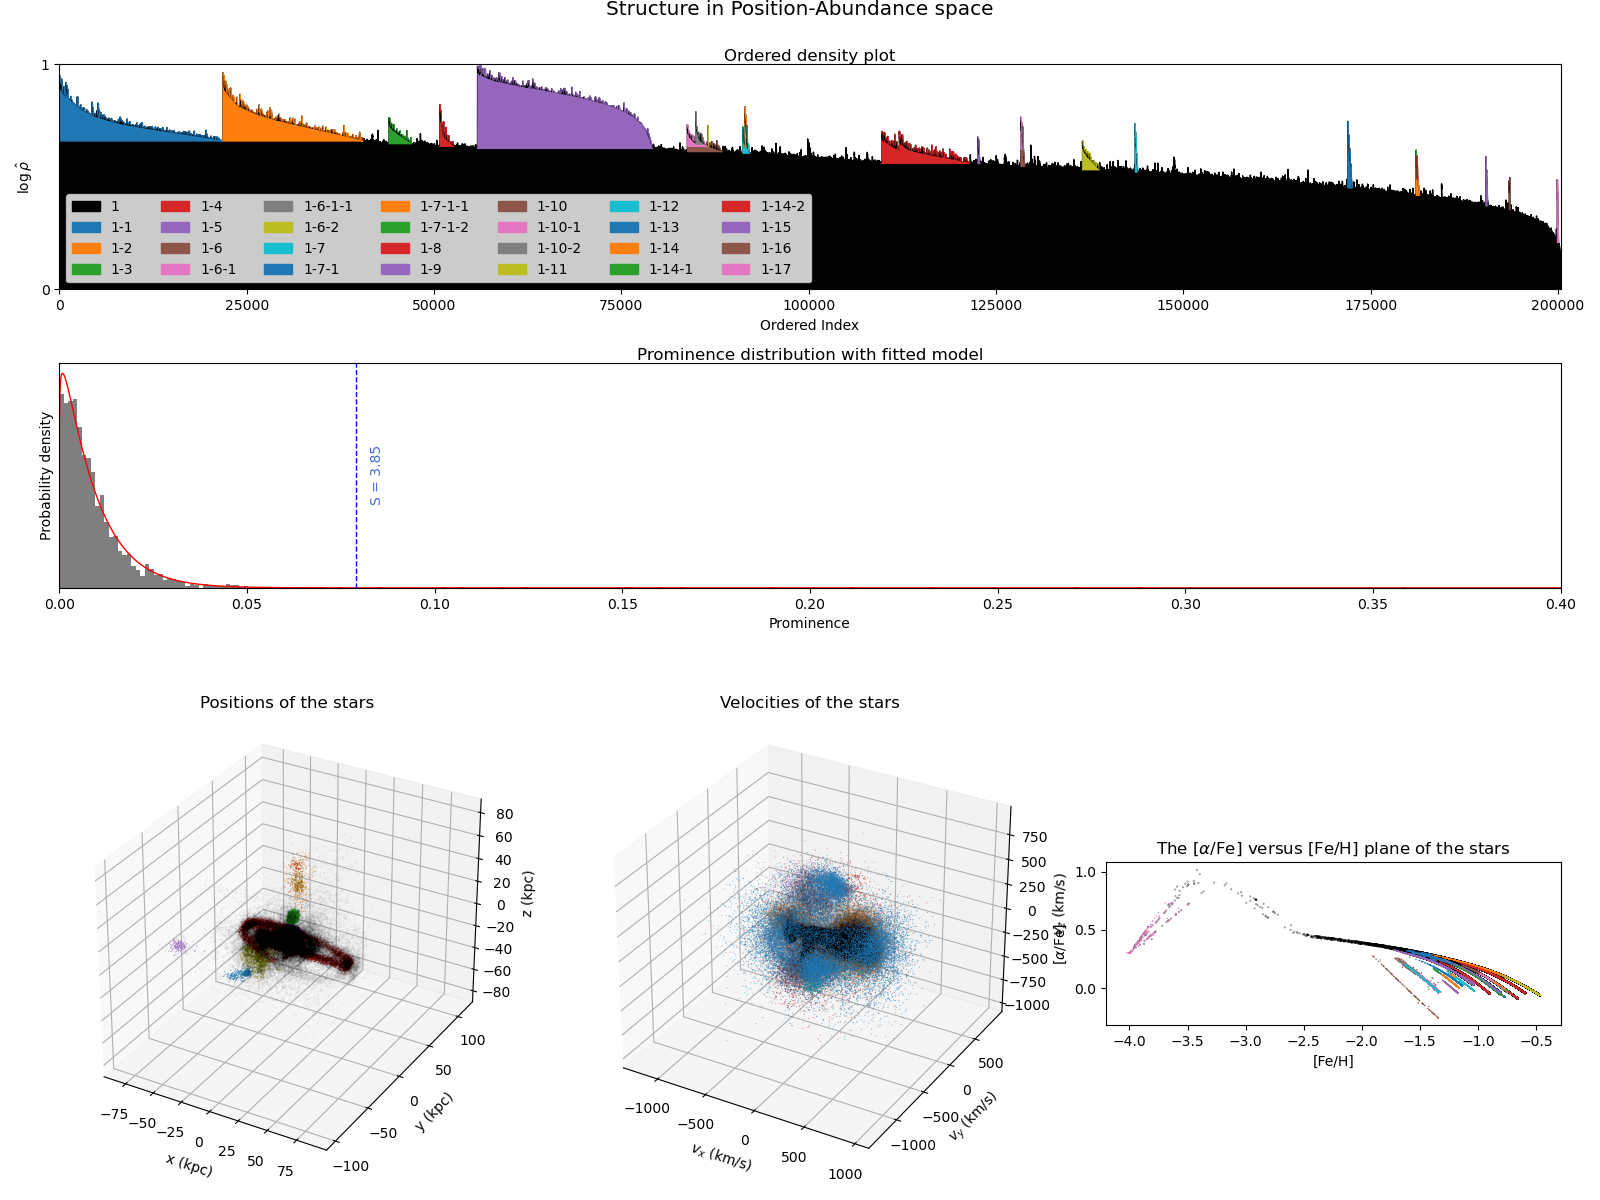

In [74]:
# Make plots for clustering in position-abundance space
make_plots(c_posabu, 'Position-Abundance')

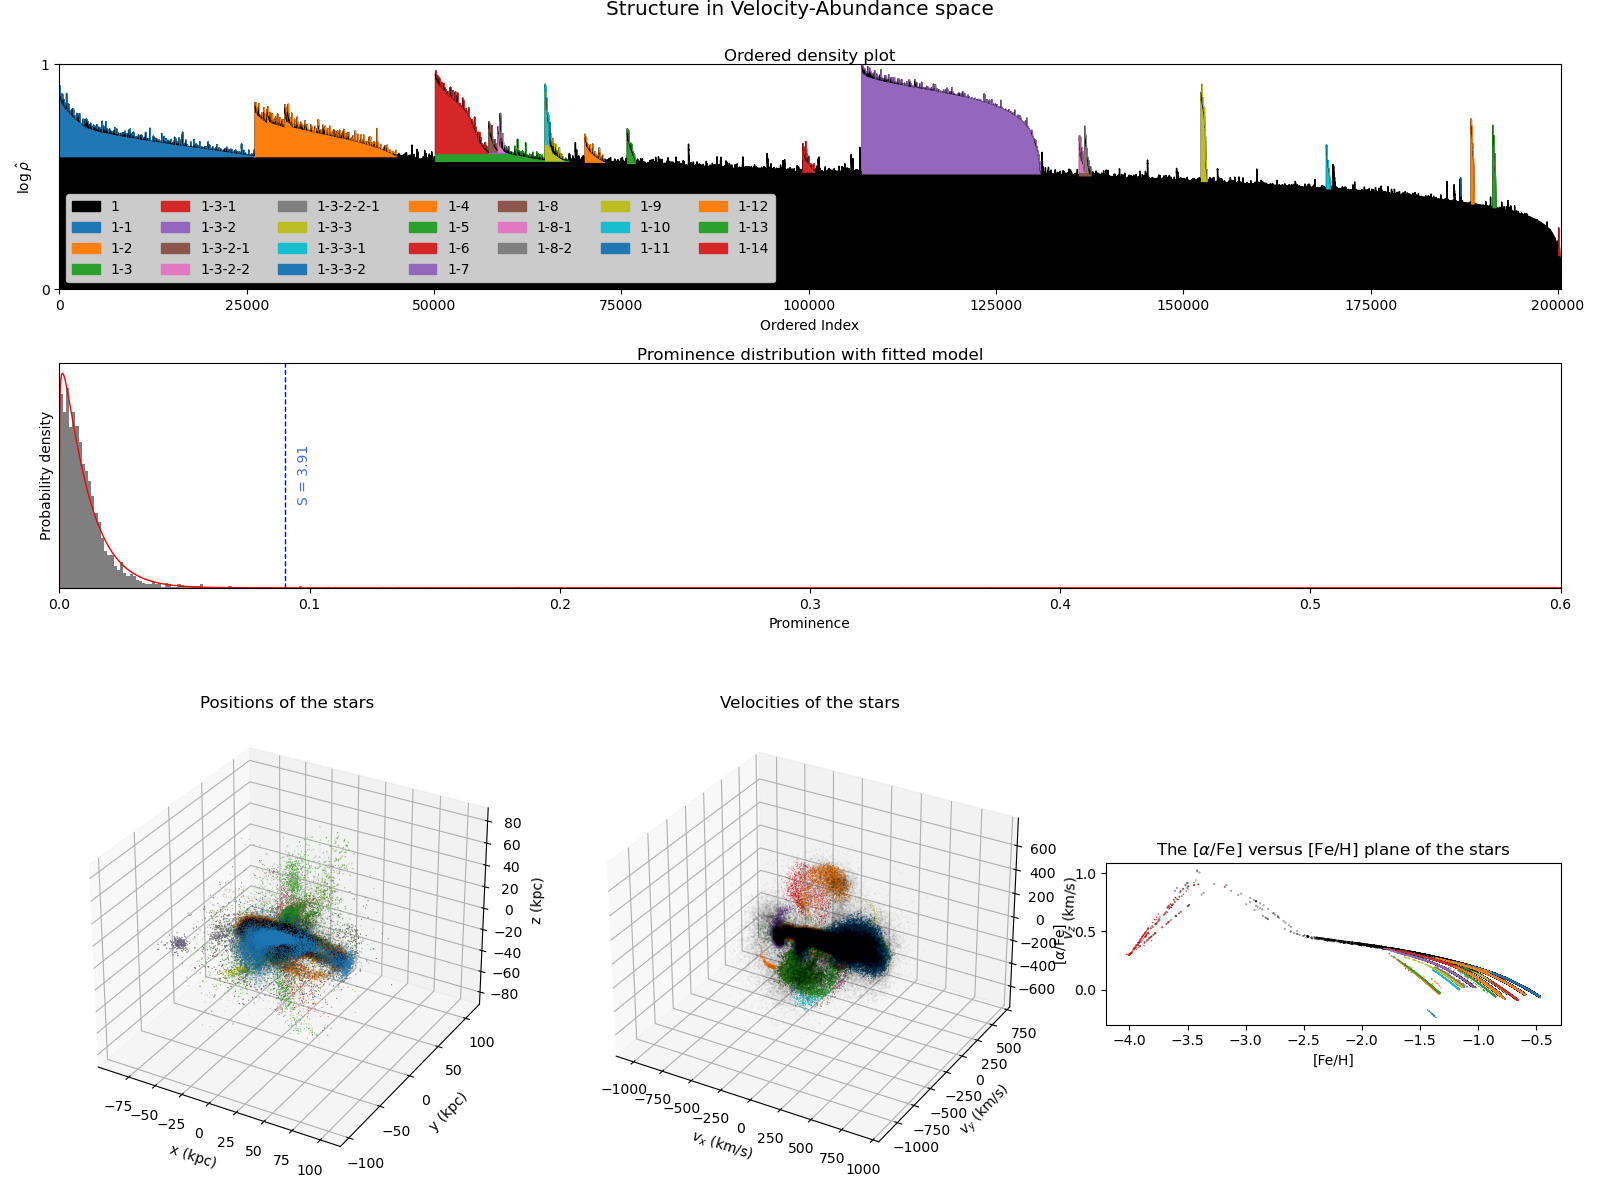

In [75]:
# Make plots for clustering in velocity-abundance space
make_plots(c_velabu, 'Velocity-Abundance')

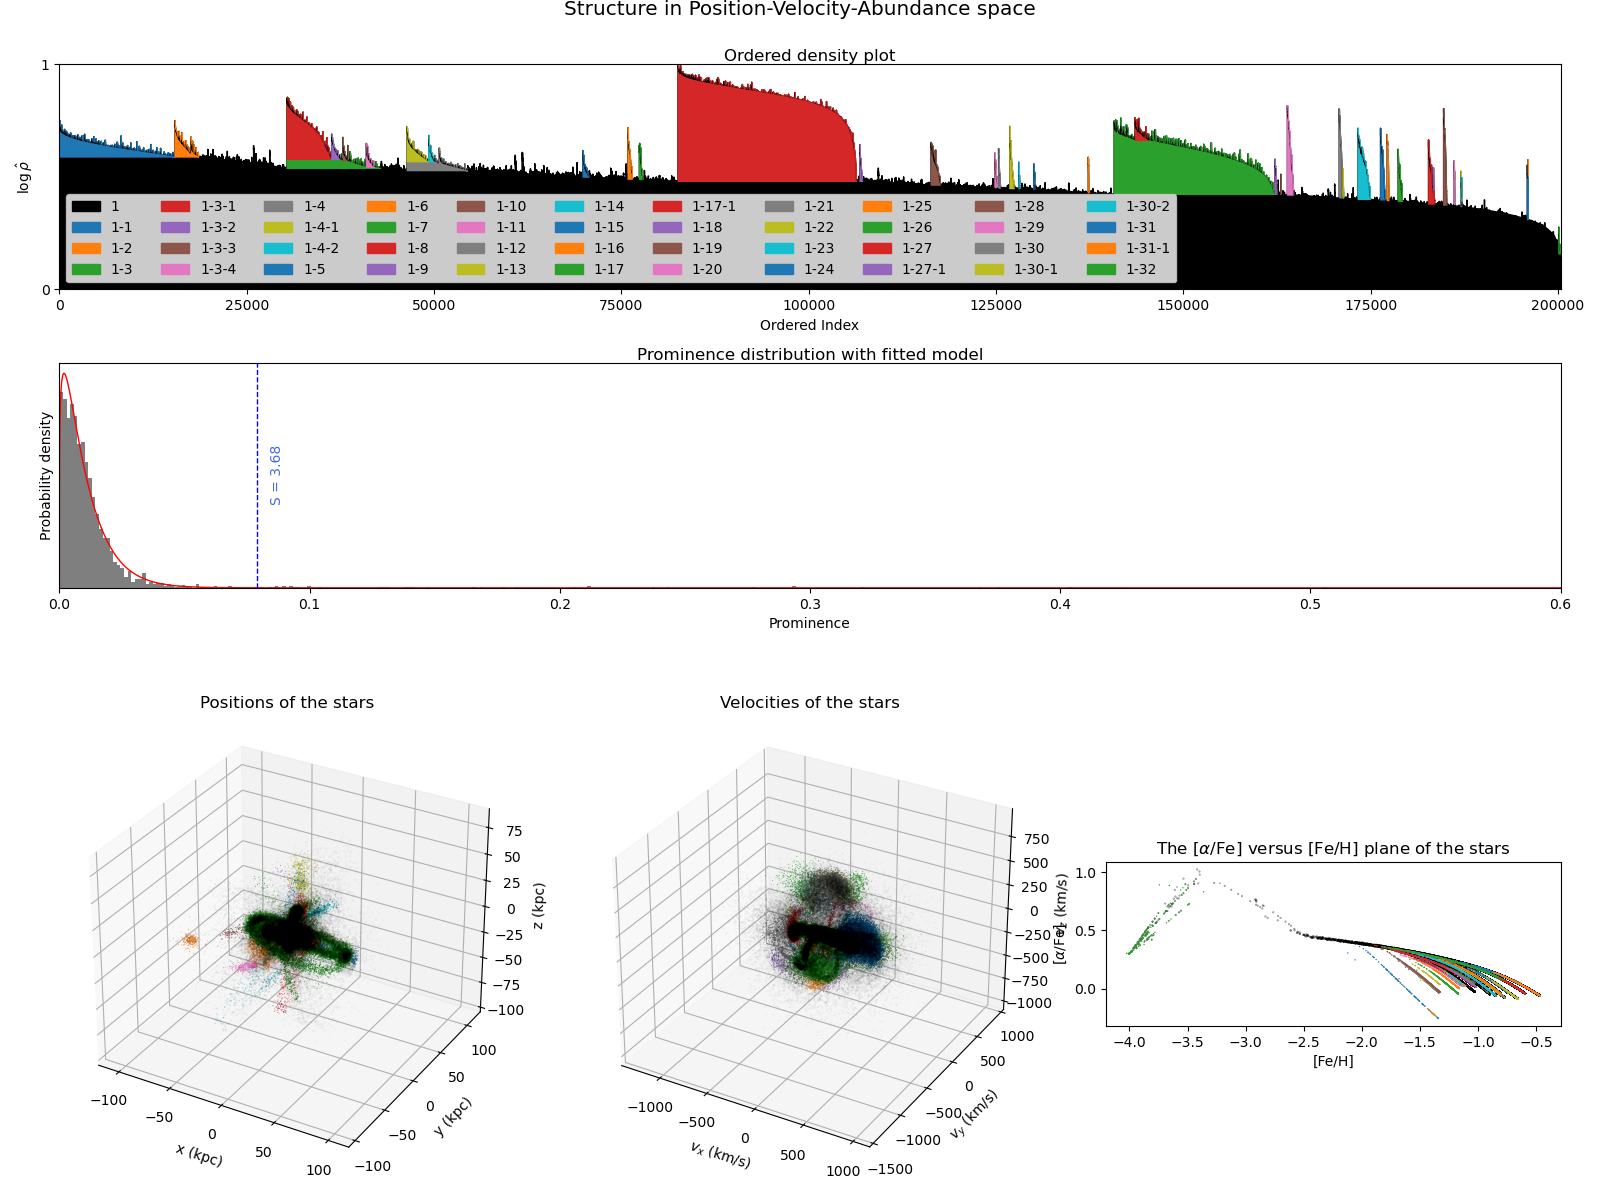

In [76]:
# Make plots for clustering in position-velocity-abundance space
make_plots(c_posvelabu, 'Position-Velocity-Abundance')

## Changing the clusters

Having observed the ordered-density plot, the prominence distribution (and fitted model), and the clusters that AstroLink has found from the data, you may wish to adjust the output.


If you wish to adjust whether the data is rescaled before clustering or not, you can change the `adaptive` attribute (`adaptive` = 1 by default, meaning that each feature is rescaled to have unit variance) and re-run AstroLink. For example;
```
c.adaptive = 0
c.run()
```


If you wish to adjust the resolution of the clustering structure (i.e. how smooth the estimated density field is and thereby how sensitive AstroLink is to fine-structure), you can change the `k_den` attribute (`k_den` = 20 by default) and re-run AstroLink. For example;
```
c.k_den = 30
c.run()
```


If you wish to adjust how well-connected the clustering structure is (i.e. the meaning of 'local' when finding structure), you can change the `k_link` attribute (`k_link` = 'auto' by default, meaning that is calculated from the `k_den` parameter and the dimensionality of the input data set) and re-run AstroLink. For example;
```
c.k_link = 10
c.run()
```

Changing any of the above attributes requires re-running AstroLink, however the following attributes can be changed without needing to re-run the entire algorithm and instead only needing to (re-)run the `extract_clusters()` method.

If you wish to adjust the style of the clustering hierarchy, you can change the `h_style` attribute (`h_style` = 1 by default) and run the `extract_clusters()` method. For example;
```
c.h_style = 0
c.extract_clusters()
```

If you wish to adjust the lower statistical significance threshold of the clusters, you can change the `S` attribute (`S` = 'auto' by default, meaning that it is calculated to best separate noise and clusters according to the prominence model fit) and run the `extract_clusters()` method. For example;
```
c.S = 5
c.extract_clusters()
```

Of course, these parameters can all be specified when initialising the AstroLink object. For example;
```
c = AstroLink(P, adaptive = 0, k_den = 30, k_link = 10, h_style = 0, S = 5)
```

## Further analysis

To do further analysis on the clustering output, the user may wish to know which points (with respect to the order in which they appear within the input data) belong to the clusters that AstroLink has found. These sets can be constructed from the `ordering` and `clusters` attributes.

```
cluster_members = [clusterer.ordering[clst[0]:clst[1]] for clst in clusterer.clusters]
```